현민영_20241001

In [3]:
import os
os.chdir(r"C:\Users\myhyu\OneDrive\Desktop\2024-2 project")

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from geopy.distance import geodesic

# 1. Dataset

## 1.1 Loading Dataset

In [5]:
geolocation = pd.read_csv('Olist_ver2\\olist_geolocation_dataset.csv')
customers = pd.read_csv('Olist_ver2\\olist_customers_dataset.csv')
orders = pd.read_csv('Olist_ver2\\olist_orders_dataset.csv')

## 1.2 geolocation 전처리
geolocation의 우편번호-좌표를 1:1매칭으로 변환  
우편번호에 좌표가 2개 이상 있는 경우, 평균으로 우편번호를 대표함.

In [6]:
# 변수명을 짧게
geolocation.columns = ['geo_code','geo_lat','geo_lng','geo_city','geo_state']
geolocation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   geo_code   1000163 non-null  int64  
 1   geo_lat    1000163 non-null  float64
 2   geo_lng    1000163 non-null  float64
 3   geo_city   1000163 non-null  object 
 4   geo_state  1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


In [7]:
# geo_code 우편번호를 'oject'로 변환
geolocation['geo_code'] = geolocation['geo_code'].astype('object')
geolocation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   geo_code   1000163 non-null  object 
 1   geo_lat    1000163 non-null  float64
 2   geo_lng    1000163 non-null  float64
 3   geo_city   1000163 non-null  object 
 4   geo_state  1000163 non-null  object 
dtypes: float64(2), object(3)
memory usage: 38.2+ MB


In [8]:
geolocation.head()

,geo_code,geo_lat,geo_lng,geo_city,geo_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


### 1.2.1 geolocation_city 정규화
city명이 악센트로 표기된 경우/영어로 표기된 경우  
2가지 표기방식이 모두 존재하므로 영어로 통일하여 문자열을 정규화  
  
2016년 기준으로 브라질의 도시(municípios) 개수는 약 5,570개 (브라질 연방정부의 공식 통계에 따른 것)

In [9]:
print(geolocation['geo_city'].unique())
print('unique한 도시명 counts :',geolocation['geo_city'].nunique())
# 도시이름이 악센트가 붙은경우, 영어인경우가 존재. 동일시 하기 위해서 정규화

['sao paulo' 'são paulo' 'sao bernardo do campo' ... 'ciríaco' 'estação'
 'vila lângaro']
unique한 도시명 counts : 8011


In [10]:
import unicodedata

# 도시 이름을 정규화하는 함수
def normalize_city(city):
    return unicodedata.normalize('NFKD', city).encode('ASCII', 'ignore').decode('utf-8').lower()

# city 컬럼 정규화
geolocation_cleaned = geolocation.copy()
geolocation_cleaned['geo_city'] = geolocation_cleaned['geo_city'].apply(normalize_city)

In [11]:
print(geolocation_cleaned['geo_city'].unique())
print(geolocation_cleaned['geo_city'].nunique())

['sao paulo' 'sao bernardo do campo' 'jundiai' ... 'floriano peixoto'
 'erebango' 'santa cecilia do sul']
5968


In [12]:
geolocation[geolocation['geo_code']==1037].head()

,geo_code,geo_lat,geo_lng,geo_city,geo_state
0,1037,-23.545621,-46.639292,sao paulo,SP
14,1037,-23.545187,-46.637855,são paulo,SP
31,1037,-23.546705,-46.640336,são paulo,SP
169,1037,-23.543883,-46.638075,são paulo,SP
178,1037,-23.546157,-46.639885,sao paulo,SP


In [13]:
geolocation_cleaned[geolocation_cleaned['geo_code']==1037].head()

,geo_code,geo_lat,geo_lng,geo_city,geo_state
0,1037,-23.545621,-46.639292,sao paulo,SP
14,1037,-23.545187,-46.637855,sao paulo,SP
31,1037,-23.546705,-46.640336,sao paulo,SP
169,1037,-23.543883,-46.638075,sao paulo,SP
178,1037,-23.546157,-46.639885,sao paulo,SP


### 1.2.2 state-city가 올바르게 분류 되었는지 확인
https://www.citypopulation.de/en/brazil/ 브라질 state별 city리스트가 있는 사이트
1. 같은 우편번호인데 state, city가 다른경우 뽑기
2. 해당 경우의 우편번호별로 수작업으로 state,city수정

In [14]:
geolocation_cleaned['geo_code'].duplicated().sum()
# 우편번호가 중복된 행 981,148rows

981148

In [15]:
# 우편번호가 같은데, state가 다른 경우
def check_different_states(group):
    # group 안에서 city/state가 모두 같은지 확인
    unique_states = group['geo_state'].nunique()
    if unique_states > 1:  # state가 다르면 해당 그룹 전체를 반환
        return group  # 동일하지 않은 행 반환
    return pd.DataFrame() 

# 중복된 우편번호들에 대해 state가 다른 경우 확인
geolocation_cleaned.groupby('geo_code').apply(check_different_states).head()

C:\Users\myhyu\AppData\Local\Temp\ipykernel_28716\747809266.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  geolocation_cleaned.groupby('geo_code').apply(check_different_states).head()


geo_code    geo_lat    geo_lng   geo_city geo_state
geo_code                                                          
2116     21728     2116 -23.522700 -46.587546  sao paulo        SP
         21759     2116 -23.518459 -46.584128  sao paulo        SP
         21788     2116 -23.518459 -46.584128  sao paulo        SP
         22060     2116 -23.519065 -46.584610  sao paulo        SP
         22193     2116 -23.519739 -46.585151  sao paulo        SP

In [16]:
geolocation_cleaned.groupby('geo_code').apply(check_different_states)['geo_code'].unique()

C:\Users\myhyu\AppData\Local\Temp\ipykernel_28716\1342676983.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  geolocation_cleaned.groupby('geo_code').apply(check_different_states)['geo_code'].unique()


array([2116, 4011, 21550, 23056, 72915, 78557, 79750, 80630], dtype=object)

In [17]:
## 2116
pd.set_option('display.max_rows', None) 
geolocation_cleaned[geolocation_cleaned.iloc[:,0] == 2116]

,geo_code,geo_lat,geo_lng,geo_city,geo_state
21728,2116,-23.522700,-46.587546,sao paulo,SP
21759,2116,-23.518459,-46.584128,sao paulo,SP
21788,2116,-23.518459,-46.584128,sao paulo,SP
22060,2116,-23.519065,-46.584610,sao paulo,SP
22193,2116,-23.519739,-46.585151,sao paulo,SP
22261,2116,-23.515978,-46.582170,sao paulo,RN
22330,2116,-23.518746,-46.583058,sao paulo,SP
22503,2116,-23.519065,-46.584610,sao paulo,SP
22638,2116,-23.522404,-46.587229,sao paulo,SP
22740,2116,-23.517004,-46.583043,sao paulo,SP


In [18]:
geolocation_cleaned[geolocation_cleaned.iloc[:,0] == 2116][geolocation_cleaned['geo_state'] != 'SP']

C:\Users\myhyu\AppData\Local\Temp\ipykernel_28716\1842023374.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  geolocation_cleaned[geolocation_cleaned.iloc[:,0] == 2116][geolocation_cleaned['geo_state'] != 'SP']


,geo_code,geo_lat,geo_lng,geo_city,geo_state
22261,2116,-23.515978,-46.58217,sao paulo,RN


In [19]:
geolocation_cleaned.loc[22261,'geo_state'] = 'SP'

In [20]:
#4011
geolocation_cleaned[geolocation_cleaned.iloc[:,0] == 4011].head()

,geo_code,geo_lat,geo_lng,geo_city,geo_state
71032,4011,-23.577404,-46.641657,sao paulo,SP
71116,4011,-23.578737,-46.642472,sao paulo,SP
71148,4011,-23.580095,-46.643086,sao paulo,SP
71152,4011,-23.579846,-46.645874,sao paulo,SP
71172,4011,-23.580095,-46.643086,sao paulo,SP


In [21]:
geolocation_cleaned[geolocation_cleaned.iloc[:,0] == 4011][geolocation_cleaned['geo_state'] != 'SP']

C:\Users\myhyu\AppData\Local\Temp\ipykernel_28716\656049867.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  geolocation_cleaned[geolocation_cleaned.iloc[:,0] == 4011][geolocation_cleaned['geo_state'] != 'SP']


,geo_code,geo_lat,geo_lng,geo_city,geo_state
72852,4011,-23.578707,-46.645779,sao paulo,AC


In [22]:
geolocation_cleaned.loc[72852,'geo_state'] = 'SP'

In [23]:
#21550
geolocation_cleaned[geolocation_cleaned.iloc[:,0] == 21550].head()

,geo_code,geo_lat,geo_lng,geo_city,geo_state
430342,21550,-22.855425,-43.367089,rio de janeiro,RJ
430344,21550,-22.860741,-43.355019,rio de janeiro,RJ
430351,21550,-22.862541,-43.360341,rio de janeiro,RJ
430352,21550,-22.861061,-43.358704,rio de janeiro,RJ
430356,21550,-22.864106,-43.356605,rio de janeiro,RJ


In [24]:
#21550
geolocation_cleaned[geolocation_cleaned.iloc[:,0] == 21550][geolocation_cleaned['geo_state'] != 'RJ']

C:\Users\myhyu\AppData\Local\Temp\ipykernel_28716\68817905.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  geolocation_cleaned[geolocation_cleaned.iloc[:,0] == 21550][geolocation_cleaned['geo_state'] != 'RJ']


,geo_code,geo_lat,geo_lng,geo_city,geo_state
430999,21550,-22.857861,-43.352613,rio de janeiro,AC


In [25]:
geolocation_cleaned.loc[430999,'geo_state'] = 'RJ'

In [26]:
# 23056
geolocation_cleaned[geolocation_cleaned.iloc[:,0] == 23056].head()

,geo_code,geo_lat,geo_lng,geo_city,geo_state
459234,23056,-22.916763,-43.615464,rio de janeiro,RJ
459247,23056,-22.918198,-43.602523,rio de janeiro,RJ
459589,23056,-22.921083,-43.615580,rio de janeiro,RJ
459689,23056,-22.916184,-43.614383,rio de janeiro,RJ
459766,23056,-22.916763,-43.615464,rio de janeiro,RJ


In [27]:
geolocation_cleaned[geolocation_cleaned.iloc[:,0] == 23056][geolocation_cleaned['geo_state'] != 'RJ']

C:\Users\myhyu\AppData\Local\Temp\ipykernel_28716\3295550851.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  geolocation_cleaned[geolocation_cleaned.iloc[:,0] == 23056][geolocation_cleaned['geo_state'] != 'RJ']


,geo_code,geo_lat,geo_lng,geo_city,geo_state
460406,23056,-22.919164,-43.611097,rio de janeiro,AC


In [28]:
geolocation_cleaned.loc[460406,'geo_state'] = 'RJ'

In [29]:
# 72915
geolocation[geolocation.iloc[:,0] == 72915].head(10) #index num: 792394

,geo_code,geo_lat,geo_lng,geo_city,geo_state
792362,72915,-15.734161,-48.268761,aguas lindas de goias,GO
792372,72915,-15.704547,-48.279205,aguas lindas de goias,GO
792373,72915,-15.715300,-48.263472,aguas lindas de goias,GO
792374,72915,-15.715300,-48.263472,aguas lindas de goias,GO
792383,72915,-15.734053,-48.268457,aguas lindas de goias,GO
792392,72915,-15.715300,-48.263472,aguas lindas de goias,GO
792394,72915,-12.408760,-46.428287,taguatinga,DF
792408,72915,-15.734053,-48.268457,aguas lindas de goias,GO
792412,72915,-15.723643,-48.268492,aguas lindas de goias,GO
792415,72915,-15.715300,-48.263472,aguas lindas de goias,GO


In [30]:
geolocation_cleaned.query('geo_city=="taguatinga" & geo_state=="TO"').head()
# 우편번호와 state 오류

,geo_code,geo_lat,geo_lng,geo_city,geo_state
817225,77320,-12.397256,-46.437391,taguatinga,TO
817252,77320,-12.403394,-46.438516,taguatinga,TO
817262,77320,-12.398432,-46.424827,taguatinga,TO
817282,77320,-12.398432,-46.424827,taguatinga,TO
817292,77320,-12.406092,-46.434581,taguatinga,TO


In [31]:
geolocation_cleaned.loc[792394,'geo_state'] = 'TO'
geolocation_cleaned.loc[792394,'geo_code'] = '77320'

In [32]:
# 78557
geolocation[geolocation.iloc[:,0] == 78557].head(10)

,geo_code,geo_lat,geo_lng,geo_city,geo_state
825876,78557,-11.877565,-55.505078,sinop,MT
825882,78557,-11.875142,-55.503020,nova brasilandia d'oeste,RO
825938,78557,-11.842027,-55.488021,sinop,MT
825975,78557,-11.891049,-55.503381,sinop,MT
825982,78557,-11.850593,-55.492015,sinop,MT
825984,78557,-11.831913,-55.487956,sinop,MT
826015,78557,-11.875191,-55.503304,sinop,MT
826114,78557,-11.868471,-55.497519,sinop,MT
826132,78557,-11.882006,-55.504392,sinop,MT
826134,78557,-11.884003,-55.500682,sinop,MT


In [33]:
geolocation[geolocation.iloc[:,0] == 78557].query('geo_state!="MT"')
# city와 state 오류

,geo_code,geo_lat,geo_lng,geo_city,geo_state
825882,78557,-11.875142,-55.50302,nova brasilandia d'oeste,RO


In [34]:
geolocation_cleaned.loc[825882,'geo_state'] = 'MT'
geolocation_cleaned.loc[825882,'geo_city'] = 'sinop'

In [35]:
# 79750
geolocation[geolocation.iloc[:,0] == 79750].head()

,geo_code,geo_lat,geo_lng,geo_city,geo_state
839731,79750,-22.253654,-53.345424,nova andradina,MS
839737,79750,-22.250279,-53.346363,nova andradina,MS
839740,79750,-22.245269,-53.355550,nova andradina,MS
839742,79750,-22.248664,-53.358334,nova andradina,MS
839747,79750,-22.255547,-53.357645,nova andradina,MS


In [36]:
geolocation[geolocation.iloc[:,0] == 79750].query('geo_state!="MS"')
# state 오류

,geo_code,geo_lat,geo_lng,geo_city,geo_state
840047,79750,-22.242062,-53.343159,nova andradina,RS


In [37]:
geolocation_cleaned.loc[840047,'geo_state'] = 'MS'

In [38]:
# 80630
geolocation[geolocation.iloc[:,0] == 80630].head()

,geo_code,geo_lat,geo_lng,geo_city,geo_state
847184,80630,-25.471721,-49.280244,curitiba,PR
847187,80630,-25.468948,-49.271134,curitiba,PR
847190,80630,-25.466005,-49.273331,curitiba,PR
847194,80630,-25.471191,-49.278918,curitiba,PR
847196,80630,-25.461689,-49.272160,curitiba,PR


In [39]:
geolocation[geolocation.iloc[:,0] == 80630].query('geo_state!="PR"')
# city, 우편번호 오류

,geo_code,geo_lat,geo_lng,geo_city,geo_state
847700,80630,-26.757371,-48.675738,balneario de picarras,SC


In [40]:
geolocation.query('geo_city=="picarras"').head()

,geo_code,geo_lat,geo_lng,geo_city,geo_state
909980,88380,-26.777352,-48.679734,picarras,SC
910415,88380,-26.772916,-48.673632,picarras,SC
910851,88380,-26.770984,-48.681967,picarras,SC
911130,88380,-26.734345,-48.682569,picarras,SC
911536,88380,-26.768525,-48.670289,picarras,SC


In [41]:
geolocation_cleaned.loc[847700,'geo_city'] = 'picarras'
geolocation_cleaned.loc[847700,'geo_code'] = '88380'

In [42]:
# 오류가 모두 수정되었는지 확인
geolocation_cleaned.groupby('geo_code').apply(check_different_states)

C:\Users\myhyu\AppData\Local\Temp\ipykernel_28716\2602355379.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  geolocation_cleaned.groupby('geo_code').apply(check_different_states)


,
geo_code,


---

### 1.2.3 우편번호의 좌표 중복 해결

In [47]:
pd.set_option('display.max_rows', 10) # 모든 행 보여주기
pd.set_option('display.max_columns', None) # 모든 열 보여주기

In [48]:
geolocation_cleaned.query('geo_code==1001')

,geo_code,geo_lat,geo_lng,geo_city,geo_state
99,1001,-23.549292,-46.633559,sao paulo,SP
206,1001,-23.550498,-46.634338,sao paulo,SP
235,1001,-23.550642,-46.634410,sao paulo,SP
299,1001,-23.549698,-46.633909,sao paulo,SP
326,1001,-23.551427,-46.634074,sao paulo,SP
...,...,...,...,...,...
1182,1001,-23.549779,-46.633957,sao paulo,SP
1246,1001,-23.549292,-46.633559,sao paulo,SP
1351,1001,-23.549951,-46.634027,sao paulo,SP
1384,1001,-23.549292,-46.633559,sao paulo,SP


In [49]:
# 우편번호별로 위도와 경도의 평균값을 계산
geolocation_avg = geolocation_cleaned.groupby('geo_code').agg({
    'geo_lat': 'mean',  # 위도의 평균값
    'geo_lng': 'mean',   # 경도의 평균값
    'geo_state' : 'first',
    'geo_city' : 'first'   
}).reset_index()

# 중복 제거된 geolocation
geolocation_avg.head()

,geo_code,geo_lat,geo_lng,geo_state,geo_city
0,1001,-23.550190,-46.634024,SP,sao paulo
1,1002,-23.548146,-46.634979,SP,sao paulo
2,1003,-23.548994,-46.635731,SP,sao paulo
3,1004,-23.549799,-46.634757,SP,sao paulo
4,1005,-23.549456,-46.636733,SP,sao paulo


In [43]:
geolocation_avg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19017 entries, 0 to 19016
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   geo_code   19017 non-null  object 
 1   geo_lat    19017 non-null  float64
 2   geo_lng    19017 non-null  float64
 3   geo_state  19017 non-null  object 
 4   geo_city   19017 non-null  object 
dtypes: float64(2), object(3)
memory usage: 743.0+ KB


In [50]:
geolocation_avg['geo_code'].duplicated().sum()
# 우편번호의 좌표 중복문제해결

0

In [51]:
geolocation_avg.columns = ['geolocation_zip_code_prefix','geolocation_lat','geolocation_lng','geolocation_state','geolocation_city']
geolocation_avg.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_state,geolocation_city
0,1001,-23.550190,-46.634024,SP,sao paulo
1,1002,-23.548146,-46.634979,SP,sao paulo
2,1003,-23.548994,-46.635731,SP,sao paulo
3,1004,-23.549799,-46.634757,SP,sao paulo
4,1005,-23.549456,-46.636733,SP,sao paulo


---
## 1.3 orders 전처리

In [52]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [53]:
orders_cleaned = orders[(orders['order_status'] != 'canceled') & (orders['order_status'] != 'unavailable')]
orders_cleaned['order_status'].unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'created',
       'approved'], dtype=object)

In [54]:
orders_cleaned.info()
# 98207

<class 'pandas.core.frame.DataFrame'>
Index: 98207 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       98207 non-null  object
 1   customer_id                    98207 non-null  object
 2   order_status                   98207 non-null  object
 3   order_purchase_timestamp       98207 non-null  object
 4   order_approved_at              98188 non-null  object
 5   order_delivered_carrier_date   97583 non-null  object
 6   order_delivered_customer_date  96470 non-null  object
 7   order_estimated_delivery_date  98207 non-null  object
dtypes: object(8)
memory usage: 6.7+ MB


---
## 1.4 customers

In [55]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [56]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [57]:
customers['customer_city'].unique()

array(['franca', 'sao bernardo do campo', 'sao paulo', ...,
       'monte bonito', 'sao rafael', 'eugenio de castro'], dtype=object)

In [59]:
'unique한 도시명 counts :',customers['customer_city'].nunique()

('unique한 도시명 counts :', 4119)

In [60]:
import unidecode

# customer_city 열의 악센트 제거
customers['customer_city'] = customers['customer_city'].apply(lambda x: unidecode.unidecode(x))
print('unique한 도시명 counts :',customers['customer_city'].nunique())

# 도시이름이 악센트 붙은경우 없음

unique한 도시명 counts : 4119


---
## 1.5 Merging DataFrame

In [61]:
df = pd.merge(orders_cleaned, customers, on='customer_id')
df = pd.merge(df, geolocation_avg, left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix')
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_state,geolocation_city
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,3149,-23.576983,-46.587161,SP,sao paulo
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,47813,-12.177924,-44.660711,BA,barreiras
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,75265,-16.745150,-48.514783,GO,vianopolis
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,59296,-5.774190,-35.271143,RN,sao goncalo do amarante
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,9195,-23.676370,-46.514627,SP,santo andre


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97933 entries, 0 to 97932
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       97933 non-null  object 
 1   customer_id                    97933 non-null  object 
 2   order_status                   97933 non-null  object 
 3   order_purchase_timestamp       97933 non-null  object 
 4   order_approved_at              97915 non-null  object 
 5   order_delivered_carrier_date   97312 non-null  object 
 6   order_delivered_customer_date  96206 non-null  object 
 7   order_estimated_delivery_date  97933 non-null  object 
 8   customer_unique_id             97933 non-null  object 
 9   customer_zip_code_prefix       97933 non-null  object 
 10  customer_city                  97933 non-null  object 
 11  customer_state                 97933 non-null  object 
 12  geolocation_zip_code_prefix    97933 non-null 

In [63]:
# 'customer_zip_code_prefix'와 'geolocation_zip_code_prefix'가 전부 일치
mismatched_rows1 = df[df['customer_zip_code_prefix'] != df['geolocation_zip_code_prefix']]
mismatched_rows1[['customer_zip_code_prefix', 'geolocation_zip_code_prefix']].head()

,customer_zip_code_prefix,geolocation_zip_code_prefix


In [64]:
# 'customer_state'와 'geolocation_state'가 전부 일치
mismatched_rows2 = df[df['customer_state'] != df['geolocation_state']]
mismatched_rows2[['customer_state', 'geolocation_state']].head()

,customer_state,geolocation_state


In [65]:
# 'customer_city'와 'geolocation_city'가 전부 일치하지 않음.
mismatched_rows3 = df[df['customer_city'] != df['geolocation_city']]
len(mismatched_rows3[['customer_city', 'geolocation_city']])
#334

334

In [66]:
# 'customer_city'와 'geolocation_city'가 일치하지 않음.
mismatched_rows3 = df[df['customer_city'] != df['geolocation_city']]
mismatched_rows3[['customer_city', 'geolocation_city']].value_counts()

customer_city     geolocation_city  
mogi-guacu        mogi guacu            60
brasilia          ceilandia             37
paraty            parati                19
embu das artes    embu                  18
embu              embu das artes        11
                                        ..
olhos d'agua      olhos-d agua           1
palmeira d oeste  palmeira d'oeste       1
pau d'arco        vila sao francisco     1
paulo afonso      gloria                 1
martinesia        tapuirama              1
Name: count, Length: 84, dtype: int64

In [67]:
import unidecode
import re

# 특수문자와 악센트를 제거하는 함수
def normalize_city_name(city):
    city = unidecode.unidecode(city)  # 악센트 제거
    city = re.sub(r'[^a-zA-Z0-9\s]', '', city)  # 특수문자 제거
    return city.lower().strip()  # 소문자로 변환하고 양쪽 공백 제거

# customer_city와 geolocation_city를 정규화
df['customer_city'] = df['customer_city'].apply(normalize_city_name)
df['geolocation_city'] = df['geolocation_city'].apply(normalize_city_name)

# 일치하지 않는 행 추출
mismatch_df = df[df['customer_city'] != df['geolocation_city']]
len(mismatch_df[['customer_city', 'geolocation_city']])
## 나머지는 수작업으로 해야 함.

333

In [68]:
# 결측
df.isna().sum()

order_id                        0
customer_id                     0
order_status                    0
order_purchase_timestamp        0
order_approved_at              18
                               ..
geolocation_zip_code_prefix     0
geolocation_lat                 0
geolocation_lng                 0
geolocation_state               0
geolocation_city                0
Length: 17, dtype: int64

In [69]:
df.to_csv('전처리1차_입지선정.csv')
#city 불일치 문제 해결해야함

###  전처리 완료사항  ###
#customer+order+geoglocation
#order_status != canceled. availabled
#좌표기준 geo_state, geo_city, geo_code 일치
#merge할때 우편번호별로 좌표 중복 해결

---
## 2. merged_df 전처리

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97933 entries, 0 to 97932
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       97933 non-null  object 
 1   customer_id                    97933 non-null  object 
 2   order_status                   97933 non-null  object 
 3   order_purchase_timestamp       97933 non-null  object 
 4   order_approved_at              97915 non-null  object 
 5   order_delivered_carrier_date   97312 non-null  object 
 6   order_delivered_customer_date  96206 non-null  object 
 7   order_estimated_delivery_date  97933 non-null  object 
 8   customer_unique_id             97933 non-null  object 
 9   customer_zip_code_prefix       97933 non-null  object 
 10  customer_city                  97933 non-null  object 
 11  customer_state                 97933 non-null  object 
 12  geolocation_zip_code_prefix    97933 non-null 

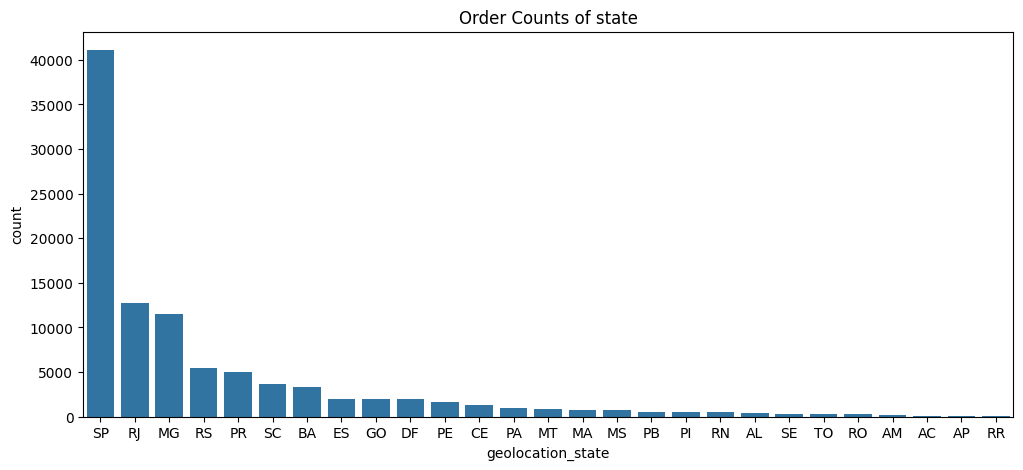

In [71]:
# merged_df의 state별 행의 개수
plt.figure(figsize=(12,5))
sns.barplot(df['geolocation_state'].value_counts())
plt.title('Order Counts of state')
plt.show()

### 2.1 customer_city와 geolocation_city의 불일치

In [72]:
df[df['customer_state']=='SP'].shape

(41112, 17)

SP의 customer_city와 geolocation_city의 불일치

In [77]:
# customer_city와 geolocation_city의 불일치 수정
df.loc[df['customer_city'] == 'mogiguacu', 'customer_city'] = 'mogi guacu'

df.loc[df['customer_city'] == 'embu das artes', 'geolocation_city'] = 'embu das artes'
df.loc[df['customer_city'] == 'embu', 'customer_city'] = 'embu das artes'

df.loc[df['customer_city'] == 'santa barbara d oeste', 'geolocation_city'] = 'santa barbara d oeste'

df.loc[df['customer_city'] == 'sao luis do paraitinga', 'customer_city'] = 'sao luiz do paraitinga'

# SP 주에서 customer_city와 geolocation_city가 일치하지 않는 경우 출력
df[(df['customer_city'] != df['geolocation_city']) & (df['geolocation_state'] == 'SP')][['customer_city', 'geolocation_city']].value_counts()


customer_city        geolocation_city   
mogi guacu           mogiguacu              31
monte alegre do sul  jaguariuna              3
guariroba            taquaritinga            2
mogimirim            mogi mirim              2
ajapi                rio claro               1
aparecida doeste     aparecida d oeste       1
estrela d oeste      estrela doeste          1
jaguariuna           monte alegre do sul     1
mogi mirim           mogimirim               1
palmeira d oeste     palmeira doeste         1
Name: count, dtype: int64

In [79]:
# customer_city와 geolocation_city의 불일치 수정
df.loc[df['customer_city'] == 'mogi guacu', 'geolocation_city'] = 'mogi guacu'
df.loc[df['customer_city'] == 'mogimirim', 'customer_city'] = 'mogi mirim'
df.loc[df['geolocation_city'] == 'mogimirim', 'geolocation_city'] = 'mogi mirim'


# SP 주에서 customer_city와 geolocation_city가 일치하지 않는 경우 출력
df[(df['customer_city'] != df['geolocation_city']) & (df['geolocation_state'] == 'SP')][['customer_city', 'geolocation_city','geolocation_lat','geolocation_lng']].value_counts()

customer_city        geolocation_city     geolocation_lat  geolocation_lng
monte alegre do sul  jaguariuna           -22.692949       -46.982878         3
guariroba            taquaritinga         -21.448306       -48.574959         2
ajapi                rio claro            -22.411490       -47.570963         1
aparecida doeste     aparecida d oeste    -20.453716       -50.882766         1
estrela d oeste      estrela doeste       -20.285485       -50.397562         1
jaguariuna           monte alegre do sul  -22.698918       -46.846496         1
palmeira d oeste     palmeira doeste      -20.415905       -50.762154         1
Name: count, dtype: int64

In [82]:
# customer_city와 geolocation_city의 불일치 수정
df.loc[df['geolocation_city'] == 'jaguariuna', 'customer_city'] = 'jaguariuna'
df.loc[df['geolocation_city'] == 'taquaritinga', 'customer_city'] = 'taquaritinga'
df.loc[df['geolocation_city'] == 'rio claro', 'customer_city'] = 'rio claro'

df.loc[df['customer_city'] == 'aparecida doeste', ['customer_city','geolocation_city']] = 'aparecida do oeste'
df.loc[df['customer_city'] == 'estrela d oeste', ['customer_city','geolocation_city']] = 'estrela do oeste'
df.loc[df['customer_city'] == 'palmeira d oeste', ['customer_city','geolocation_city']] = 'palmeira do oeste'

df.loc[df['customer_city'] == 'jaguariuna', ['customer_city','geolocation_city']] = 'amparo'

# SP 주에서 customer_city와 geolocation_city가 일치하지 않는 경우 출력
df[(df['customer_city'] != df['geolocation_city']) & (df['geolocation_state'] == 'SP')][['customer_city', 'geolocation_city','geolocation_lat','geolocation_lng']].value_counts()

Series([], Name: count, dtype: int64)

state BA

In [83]:
df[df['geolocation_state']=='BA'].shape
#3,336

(3336, 17)

In [85]:
df.query('geolocation_state=="BA"').info()

<class 'pandas.core.frame.DataFrame'>
Index: 3336 entries, 1 to 97930
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       3336 non-null   object 
 1   customer_id                    3336 non-null   object 
 2   order_status                   3336 non-null   object 
 3   order_purchase_timestamp       3336 non-null   object 
 4   order_approved_at              3336 non-null   object 
 5   order_delivered_carrier_date   3316 non-null   object 
 6   order_delivered_customer_date  3248 non-null   object 
 7   order_estimated_delivery_date  3336 non-null   object 
 8   customer_unique_id             3336 non-null   object 
 9   customer_zip_code_prefix       3336 non-null   object 
 10  customer_city                  3336 non-null   object 
 11  customer_state                 3336 non-null   object 
 12  geolocation_zip_code_prefix    3336 non-null   objec

In [88]:
# 'customer_city'와 'geolocation_city'가 전부 일치하지 않음.
mismatched_rows_BA = df.query('geolocation_state == "BA"')[
    df['customer_city'] != df['geolocation_city']
]
len(mismatched_rows_BA[['customer_city', 'geolocation_city']])
#25

C:\Users\myhyu\AppData\Local\Temp\ipykernel_28716\6353208.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mismatched_rows_BA = df.query('geolocation_state == "BA"')[


25

In [91]:
mismatched_rows_BA[['customer_city', 'geolocation_city','geolocation_lat','geolocation_lng']].value_counts()

customer_city             geolocation_city         geolocation_lat  geolocation_lng
nucleo residencial pilar  jaguarari                -10.333614       -40.151525         8
posto da mata             nova vicosa              -17.886450       -39.861698         4
itamira                   apora                    -13.468836       -39.240260         2
muquem do sao francisco   muquem de sao francisco  -12.114786       -43.553055         2
santa teresinha           santa terezinha          -12.745713       -39.520316         2
                                                                                      ..
camacari                  abrantes                 -12.829741       -38.264986         1
dias d avila              dias davila              -12.613382       -38.301073         1
paulo afonso              gloria                   -9.441492        -38.223191         1
porto seguro              arraial dajuda           -16.400187       -39.262747         1
taboquinhas               

In [92]:
# customer_city와 geolocation_city의 불일치 수정1
df.loc[df['geolocation_city'] == 'jaguarari', 'customer_city'] = 'jaguarari'
df.loc[df['customer_city'] == 'posto da mata', 'geolocation_city'] = 'posto da mata'
df.loc[df['customer_city'] == 'itamira', ['customer_city','geolocation_city']] = 'valenca'
df.loc[df['customer_city'] == 'muquem do sao francisco', 'geolocation_city'] = 'muquem do sao francisco'
df.loc[df['customer_city'] == 'santa teresinha', 'geolocation_city'] = 'santa teresinha'

# SP 주에서 customer_city와 geolocation_city가 일치하지 않는 경우 출력
df[(df['customer_city'] != df['geolocation_city']) & (df['geolocation_state'] == 'BA')][['customer_city', 'geolocation_city','geolocation_lat','geolocation_lng']].value_counts()

customer_city    geolocation_city  geolocation_lat  geolocation_lng
arraial d ajuda  arraial dajuda    -16.400187       -39.262747         1
caldas do jorro  tucano            -11.027780       -38.791895         1
camacari         abrantes          -12.829741       -38.264986         1
dias d avila     dias davila       -12.613382       -38.301073         1
paulo afonso     gloria            -9.441492        -38.223191         1
porto seguro     arraial dajuda    -16.400187       -39.262747         1
taboquinhas      itacare           -14.277952       -38.995374         1
Name: count, dtype: int64

In [93]:
# customer_city와 geolocation_city의 불일치 수정2
df.loc[df['geolocation_city'] == 'arraial dajuda', ['customer_city','geolocation_city']] = 'porto seguro'
df.loc[df['geolocation_city'] == 'tucano', 'customer_city'] = 'tucano'
df.loc[df['customer_city'] == 'camacari', 'geolocation_city'] = 'camacari'
df.loc[df['customer_city'] == 'dias d avila', ['customer_city','geolocation_city']] = 'camacari'
df.loc[df['customer_city'] == 'paulo afonso', 'geolocation_city'] = 'paulo afonso'
df.loc[df['customer_city'] == 'porto seguro', 'geolocation_city'] = 'porto seguro'
df.loc[df['geolocation_city'] == 'itacare', 'customer_city'] = 'itacare'

# SP 주에서 customer_city와 geolocation_city가 일치하지 않는 경우 출력
df[(df['customer_city'] != df['geolocation_city']) & (df['geolocation_state'] == 'BA')][['customer_city', 'geolocation_city','geolocation_lat','geolocation_lng']].value_counts()

Series([], Name: count, dtype: int64)

In [99]:
df[(df['customer_city'] != df['geolocation_city']) & 
                     (df['customer_state'].isin(['SP', 'BA']))]
# SP와 BA 주에 대해서 city가 불일치하는 문제 

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_state,geolocation_city


#### 동일한 행 제거

In [101]:
df[(df['customer_state'] != df['geolocation_state']) & 
                     (df['customer_state'].isin(['SP', 'BA']))]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_state,geolocation_city


In [102]:
df[(df['customer_city'] != df['geolocation_city']) & 
                     (df['customer_state'].isin(['SP', 'BA']))]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_state,geolocation_city


In [103]:
df[(df['customer_zip_code_prefix'] != df['geolocation_zip_code_prefix']) & 
                     (df['customer_state'].isin(['SP', 'BA']))]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_state,geolocation_city


In [105]:
df.drop(columns=['geolocation_zip_code_prefix','geolocation_city','geolocation_state'], inplace=True)
df.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'geolocation_lat', 'geolocation_lng'],
      dtype='object')

### 2.2 파생변수 (소요시간)
- 주문-승인 시간  
df['time_difference_0'] = df['order_approved_at'] - df['order_purchase_timestamp']

- 승인-물류업체전달 시간  
df['time_difference_1'] = df['order_delivered_carrier_date'] - df['order_approved_at']

- 물류업체전달- 배송완료 시간  
df['time_difference_2'] = df['order_delivered_customer_date'] - df['order_delivered_carrier_date']

- 총 배송소요 시간  
df['time_difference_total'] = df['order_delivered_customer_date'] - df['order_purchase_timestamp']

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97933 entries, 0 to 97932
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       97933 non-null  object 
 1   customer_id                    97933 non-null  object 
 2   order_status                   97933 non-null  object 
 3   order_purchase_timestamp       97933 non-null  object 
 4   order_approved_at              97915 non-null  object 
 5   order_delivered_carrier_date   97312 non-null  object 
 6   order_delivered_customer_date  96206 non-null  object 
 7   order_estimated_delivery_date  97933 non-null  object 
 8   customer_unique_id             97933 non-null  object 
 9   customer_zip_code_prefix       97933 non-null  object 
 10  customer_city                  97933 non-null  object 
 11  customer_state                 97933 non-null  object 
 12  geolocation_zip_code_prefix    97933 non-null 

In [106]:
# datetime 형식 변환
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'], errors='coerce')
df['order_approved_at'] = pd.to_datetime(df['order_approved_at'], errors='coerce')
df['order_delivered_carrier_date'] = pd.to_datetime(df['order_delivered_carrier_date'], errors='coerce')
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'], errors='coerce')
df['order_estimated_delivery_date'] = pd.to_datetime(df['order_estimated_delivery_date'], errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97933 entries, 0 to 97932
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       97933 non-null  object        
 1   customer_id                    97933 non-null  object        
 2   order_status                   97933 non-null  object        
 3   order_purchase_timestamp       97933 non-null  datetime64[ns]
 4   order_approved_at              97915 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97312 non-null  datetime64[ns]
 6   order_delivered_customer_date  96206 non-null  datetime64[ns]
 7   order_estimated_delivery_date  97933 non-null  datetime64[ns]
 8   customer_unique_id             97933 non-null  object        
 9   customer_zip_code_prefix       97933 non-null  object        
 10  customer_city                  97933 non-null  object        
 11  customer_state 

In [107]:
# 주문-승인 시간
df['time_difference_0'] = df['order_approved_at'] - df['order_purchase_timestamp']

# 승인-물류업체전달 시간
df['time_difference_1'] = df['order_delivered_carrier_date'] - df['order_approved_at']

# 물류업체전달- 배송완료 시간
df['time_difference_2'] = df['order_delivered_customer_date'] - df['order_delivered_carrier_date']

# 총 배송소요 시간
df['time_difference_total'] = df['order_delivered_customer_date'] - df['order_purchase_timestamp']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97933 entries, 0 to 97932
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype          
---  ------                         --------------  -----          
 0   order_id                       97933 non-null  object         
 1   customer_id                    97933 non-null  object         
 2   order_status                   97933 non-null  object         
 3   order_purchase_timestamp       97933 non-null  datetime64[ns] 
 4   order_approved_at              97915 non-null  datetime64[ns] 
 5   order_delivered_carrier_date   97312 non-null  datetime64[ns] 
 6   order_delivered_customer_date  96206 non-null  datetime64[ns] 
 7   order_estimated_delivery_date  97933 non-null  datetime64[ns] 
 8   customer_unique_id             97933 non-null  object         
 9   customer_zip_code_prefix       97933 non-null  object         
 10  customer_city                  97933 non-null  object         
 11  cu

In [114]:
df.to_csv('전처리1차_입지선정.csv', encoding='cp949', index=False)

## 2.3 df_SP, df_BA

In [115]:
df_SP = df.loc[df['customer_state']=='SP']
df_SP.info()
# orders counts = 41,112

<class 'pandas.core.frame.DataFrame'>
Index: 41112 entries, 0 to 97929
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype          
---  ------                         --------------  -----          
 0   order_id                       41112 non-null  object         
 1   customer_id                    41112 non-null  object         
 2   order_status                   41112 non-null  object         
 3   order_purchase_timestamp       41112 non-null  datetime64[ns] 
 4   order_approved_at              41106 non-null  datetime64[ns] 
 5   order_delivered_carrier_date   40813 non-null  datetime64[ns] 
 6   order_delivered_customer_date  40480 non-null  datetime64[ns] 
 7   order_estimated_delivery_date  41112 non-null  datetime64[ns] 
 8   customer_unique_id             41112 non-null  object         
 9   customer_zip_code_prefix       41112 non-null  object         
 10  customer_city                  41112 non-null  object         
 11  custome

In [116]:
df_SP.to_csv('전처리1차_입지선정_SP.csv', encoding='cp949', index=False)

In [117]:
df_BA = df.loc[df['customer_state']=='BA']
df_BA.info()
# orders counts = 3,336

<class 'pandas.core.frame.DataFrame'>
Index: 3336 entries, 1 to 97930
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype          
---  ------                         --------------  -----          
 0   order_id                       3336 non-null   object         
 1   customer_id                    3336 non-null   object         
 2   order_status                   3336 non-null   object         
 3   order_purchase_timestamp       3336 non-null   datetime64[ns] 
 4   order_approved_at              3336 non-null   datetime64[ns] 
 5   order_delivered_carrier_date   3316 non-null   datetime64[ns] 
 6   order_delivered_customer_date  3248 non-null   datetime64[ns] 
 7   order_estimated_delivery_date  3336 non-null   datetime64[ns] 
 8   customer_unique_id             3336 non-null   object         
 9   customer_zip_code_prefix       3336 non-null   object         
 10  customer_city                  3336 non-null   object         
 11  customer

In [118]:
df_BA.to_csv('전처리1차_입지선정_BA.csv', encoding='cp949', index=False)